# Загрузка библиотек

In [1]:
import clip
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import torch
from torch import cdist
import torch.nn as nn
from torch.nn.functional import cosine_similarity
from torchmetrics.functional import retrieval_precision, retrieval_recall, retrieval_hit_rate
from torchmetrics.functional import accuracy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from transformers import CLIPProcessor,CLIPTokenizer, CLIPModel, AdamW
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

C:\Users\Андюкаев\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Оределение устройства

In [2]:
# Определение устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка предварительно обученой модели процессора токинезатора и опрделение оптимизатора

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
optimizer = AdamW(model.parameters(), lr=1e-8, betas=(0.9, 0.98), eps=1e-7, weight_decay=0.3)

C:\Users\Андюкаев\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Определение класса MineralClipFineTuningDataset

Определяется класс MineralClipFineTuningDataset, который является наследником класса Dataset. Класс MineralClipFineTuningDataset используется для подготовки набора данных, который используется для дообучения (fune-tuning) модели CLIP

In [4]:
class MineralClipFineTuningDataset(Dataset):

  def __init__(self, tokenizer, processor, transforms, data_root="", data_file="minerals_10_clean_updated_with_folders.csv"):

     self.data = pd.read_csv(
         data_file if not data_root else os.path.join(data_root, data_file),
                                                                   encoding="utf-8", on_bad_lines="warn")

     self.data = self.data.dropna(subset=["en_description", "en_name"])

     self.tokenizer = tokenizer
     self.processor = processor
     self.transform = transforms


     self.label_dict = {mineral: idx for idx, mineral in enumerate(self.data["en_name"].unique().tolist())}
     self.name_dict = {idx: mineral for mineral, idx in self.label_dict.items()}

     self.image_names, self.descriptions, self.labels = self.data["path"].tolist(),\
                                                self.data["en_description"].tolist(), self.data["en_name"].tolist()

  def __getitem__(self, idx):
      img_name = self.image_names[idx]
      image = Image.open(img_name).convert("RGB")

      text_description = self.descriptions[idx]
      text_inputs = self.tokenizer(text_description, return_tensors="pt", padding="max_length", truncation=True,
                                   max_length=77)
      image_inputs = self.processor(images=image, return_tensors="pt")
      pixel_values = image_inputs["pixel_values"].squeeze(0)
      return pixel_values, text_inputs['input_ids'].squeeze(0), self.label_dict[self.labels[idx]]

  def __len__(self):
    return len(self.image_names)


if __name__ == "__main__":
  processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
  clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

  mineral_dataset = MineralClipFineTuningDataset(clip_tokenizer, processor, transforms=transforms)
  ###print mineral-name-to-class id
  print(mineral_dataset.label_dict)
  ###print mineral-name-to-class id
  print(mineral_dataset.name_dict)

{'quartz': 0, 'topaz': 1, 'hematite': 2, 'chalcedony': 3, 'corundum': 4, 'beryl': 5, 'magnetite': 6, 'agate': 7, 'cassiterite': 8, 'calcite': 9}
{0: 'quartz', 1: 'topaz', 2: 'hematite', 3: 'chalcedony', 4: 'corundum', 5: 'beryl', 6: 'magnetite', 7: 'agate', 8: 'cassiterite', 9: 'calcite'}


Списки выводились для проверки

# Подготовка данных

In [5]:
# Примеры преобразований для данных
train_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),           # Преобразование в тензор
])

val_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

In [6]:
# Создаем загрузчики данных
train_dataset = MineralClipFineTuningDataset(clip_tokenizer, processor, train_transform, data_root="", data_file="train.csv")
val_dataset = MineralClipFineTuningDataset(clip_tokenizer, processor, val_transform, data_root="", data_file="val.csv")

# Обновляем DataLoader, чтобы использовать пользовательскую функцию объединения
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Обучение модели

Обучение и валидация модели:
- модель переводится в режим обучения (model.train());
- обучающие данные передаются через загрузчик данных (train_dataloader);
- вычисляются выходы модели и потери на каждом батче;
- обновляются веса модели с помощью оптимизатора;
- после каждой эпохи вычисляется среднее значение потерь;
- выполняется оценка качества модели на валидационных данных;
- после завершения всех эпох обучения сохраняется итоговая модель.

In [7]:
# Установка переменной окружения CUDA_LAUNCH_BLOCKING=1
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

loss_img = CrossEntropyLoss()
loss_txt = CrossEntropyLoss()

# Создаем директорию для чекпоинтов, если ее еще нет
checkpoint_path = "./checkpoints"
os.makedirs(checkpoint_path, exist_ok=True)

num_epochs = 53
patience = 10  # Для раннего прекращения
best_val_loss = float('inf')
no_improvement_epochs = 0

losses = []
val_losses = []

# Для логирования в TensorBoard
writer = SummaryWriter()

# Планировщик скорости обучения
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Начало цикла обучения
for epoch in range(num_epochs):
    epoch_losses = []
    pbar = tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    model.train()
    for batch_idx, (images, texts, labels) in enumerate(pbar):
        optimizer.zero_grad()

        images = images.to(device)
        texts = texts.to(device)
        labels = labels.to(device)
       
        outputs = model(pixel_values=images, input_ids=texts)
        logits_per_image, logits_per_text = outputs.logits_per_image, outputs.logits_per_text

        ground_truth = torch.arange(images.size(0), dtype=torch.long, device=device)
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
        
        epoch_losses.append(total_loss.item())
        total_loss.backward()
        optimizer.step()
        
        pbar.set_postfix(loss=total_loss.item())
    
    epoch_avg_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(epoch_avg_loss)
    writer.add_scalar('Loss/train', epoch_avg_loss, epoch)
    print(f"Loss after epoch {epoch+1}: {epoch_avg_loss}")

    # Создаем чекпоинт
    checkpoint_file = os.path.join(checkpoint_path, f"checkpoint_epoch_{epoch+1}.pt")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_avg_loss,
    }, checkpoint_file)
    
    # Освобождаем память GPU
    torch.cuda.empty_cache()

    # Валидация модели
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for images, texts, labels in val_dataloader:
            images = images.to(device)
            texts = texts.to(device)
            labels = labels.to(device)

            outputs = model(pixel_values=images, input_ids=texts)
            logits_per_image, logits_per_text = outputs.logits_per_image, outputs.logits_per_text

            ground_truth = torch.arange(images.size(0), dtype=torch.long, device=device)
            total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
            val_loss += total_loss.item()

        val_avg_loss = val_loss / len(val_dataloader)
        val_losses.append(val_avg_loss)
        writer.add_scalar('Loss/val', val_avg_loss, epoch)
        print(f"Validation Loss after epoch {epoch+1}: {val_avg_loss}")

        # Обновляем планировщик скорости обучения
        scheduler.step(val_avg_loss)

        # Раннее прекращение
        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
            if no_improvement_epochs >= patience:
                print("Early stopping triggered")
                break
    
# Сохраняем итоговую модель
final_model_path = "./minerals_clip_final"
model.save_pretrained(final_model_path)
processor.save_pretrained(final_model_path)

# Закрываем логгер
writer.close()

C:\Users\Андюкаев\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/53: 100%|██████████| 157/157 [07:51<00:00,  3.00s/it, loss=1.5]  


Loss after epoch 1: 2.1915762959771854
Validation Loss after epoch 1: 2.218256928026676


Epoch 2/53: 100%|██████████| 157/157 [07:04<00:00,  2.70s/it, loss=1.44] 


Loss after epoch 2: 2.127206334642544
Validation Loss after epoch 2: 2.1674129938085875


Epoch 3/53: 100%|██████████| 157/157 [07:11<00:00,  2.75s/it, loss=1.39] 


Loss after epoch 3: 2.0680444470256756
Validation Loss after epoch 3: 2.120129331946373


Epoch 4/53: 100%|██████████| 157/157 [07:04<00:00,  2.71s/it, loss=1.35] 


Loss after epoch 4: 2.0126552676698966
Validation Loss after epoch 4: 2.076114689310392


Epoch 5/53: 100%|██████████| 157/157 [07:08<00:00,  2.73s/it, loss=1.31] 


Loss after epoch 5: 1.9606587336321546
Validation Loss after epoch 5: 2.035135387132565


Epoch 6/53: 100%|██████████| 157/157 [07:01<00:00,  2.68s/it, loss=1.27] 


Loss after epoch 6: 1.9117425803545933
Validation Loss after epoch 6: 1.9969907415409882


Epoch 7/53: 100%|██████████| 157/157 [06:59<00:00,  2.68s/it, loss=1.23] 


Loss after epoch 7: 1.865637447803643
Validation Loss after epoch 7: 1.961504239588976


Epoch 8/53: 100%|██████████| 157/157 [07:01<00:00,  2.68s/it, loss=1.2]  


Loss after epoch 8: 1.82212251045142
Validation Loss after epoch 8: 1.9285083127518494


Epoch 9/53: 100%|██████████| 157/157 [07:10<00:00,  2.74s/it, loss=1.17] 


Loss after epoch 9: 1.7810132613607272
Validation Loss after epoch 9: 1.8978295102715492


Epoch 10/53: 100%|██████████| 157/157 [06:46<00:00,  2.59s/it, loss=1.14] 


Loss after epoch 10: 1.7421475977275023
Validation Loss after epoch 10: 1.8693021709720294


Epoch 11/53: 100%|██████████| 157/157 [07:00<00:00,  2.68s/it, loss=1.12] 


Loss after epoch 11: 1.7053577917016995
Validation Loss after epoch 11: 1.842753096173207


Epoch 12/53: 100%|██████████| 157/157 [07:00<00:00,  2.68s/it, loss=1.09] 


Loss after epoch 12: 1.6704717100046242
Validation Loss after epoch 12: 1.8180075883865356


Epoch 13/53: 100%|██████████| 157/157 [07:00<00:00,  2.68s/it, loss=1.07] 


Loss after epoch 13: 1.6373134101652036
Validation Loss after epoch 13: 1.7948877960443497


Epoch 14/53: 100%|██████████| 157/157 [06:59<00:00,  2.67s/it, loss=1.04] 


Loss after epoch 14: 1.6057105409871242
Validation Loss after epoch 14: 1.773225807895263


Epoch 15/53: 100%|██████████| 157/157 [07:00<00:00,  2.68s/it, loss=1.02] 


Loss after epoch 15: 1.5755012929439545
Validation Loss after epoch 15: 1.7528634642561276


Epoch 16/53: 100%|██████████| 157/157 [07:06<00:00,  2.71s/it, loss=0.995]


Loss after epoch 16: 1.546540152115427
Validation Loss after epoch 16: 1.7336662088831265


Epoch 17/53: 100%|██████████| 157/157 [07:09<00:00,  2.74s/it, loss=0.973]


Loss after epoch 17: 1.518700169909532
Validation Loss after epoch 17: 1.7155102553466957


Epoch 18/53: 100%|██████████| 157/157 [06:59<00:00,  2.67s/it, loss=0.951]


Loss after epoch 18: 1.491874479564132
Validation Loss after epoch 18: 1.6983012594282627


Epoch 19/53: 100%|██████████| 157/157 [07:02<00:00,  2.69s/it, loss=0.93] 


Loss after epoch 19: 1.4659710306270866
Validation Loss after epoch 19: 1.6819468786319096


Epoch 20/53: 100%|██████████| 157/157 [06:59<00:00,  2.67s/it, loss=0.909]


Loss after epoch 20: 1.4409110530926164
Validation Loss after epoch 20: 1.6663785688579082


Epoch 21/53: 100%|██████████| 157/157 [07:01<00:00,  2.68s/it, loss=0.889]


Loss after epoch 21: 1.416625817110584
Validation Loss after epoch 21: 1.6515289917588234


Epoch 22/53: 100%|██████████| 157/157 [06:58<00:00,  2.67s/it, loss=0.868]


Loss after epoch 22: 1.3930509963612647
Validation Loss after epoch 22: 1.637346126139164


Epoch 23/53: 100%|██████████| 157/157 [07:01<00:00,  2.68s/it, loss=0.848]


Loss after epoch 23: 1.3701456673206038
Validation Loss after epoch 23: 1.623794445147117


Epoch 24/53: 100%|██████████| 157/157 [07:01<00:00,  2.69s/it, loss=0.829]


Loss after epoch 24: 1.3478860217294875
Validation Loss after epoch 24: 1.6108303740620613


Epoch 25/53: 100%|██████████| 157/157 [07:12<00:00,  2.75s/it, loss=0.809]


Loss after epoch 25: 1.3262156188298182
Validation Loss after epoch 25: 1.5984173615773518


Epoch 26/53: 100%|██████████| 157/157 [06:59<00:00,  2.67s/it, loss=0.79] 


Loss after epoch 26: 1.3050938514387531
Validation Loss after epoch 26: 1.5865169862906139


Epoch 27/53: 100%|██████████| 157/157 [07:01<00:00,  2.69s/it, loss=0.771]


Loss after epoch 27: 1.2844897424149666
Validation Loss after epoch 27: 1.575099341571331


Epoch 28/53: 100%|██████████| 157/157 [06:59<00:00,  2.67s/it, loss=0.752]


Loss after epoch 28: 1.2643725304466904
Validation Loss after epoch 28: 1.564140475044648


Epoch 29/53: 100%|██████████| 157/157 [07:02<00:00,  2.69s/it, loss=0.733]


Loss after epoch 29: 1.2447153817696177
Validation Loss after epoch 29: 1.5536124209562938


Epoch 30/53: 100%|██████████| 157/157 [06:59<00:00,  2.67s/it, loss=0.715]


Loss after epoch 30: 1.2254926156086527
Validation Loss after epoch 30: 1.5434933143357437


Epoch 31/53: 100%|██████████| 157/157 [07:03<00:00,  2.69s/it, loss=0.696]


Loss after epoch 31: 1.2066808259411224
Validation Loss after epoch 31: 1.5337632757922013


Epoch 32/53: 100%|██████████| 157/157 [07:01<00:00,  2.68s/it, loss=0.678]


Loss after epoch 32: 1.1882595799531146
Validation Loss after epoch 32: 1.5244025054077308


Epoch 33/53: 100%|██████████| 157/157 [07:11<00:00,  2.75s/it, loss=0.66] 


Loss after epoch 33: 1.1702082814874164
Validation Loss after epoch 33: 1.5153895914554596


Epoch 34/53: 100%|██████████| 157/157 [06:58<00:00,  2.67s/it, loss=0.642]


Loss after epoch 34: 1.1525094691355517
Validation Loss after epoch 34: 1.5067127496004105


Epoch 35/53: 100%|██████████| 157/157 [07:01<00:00,  2.68s/it, loss=0.624]


Loss after epoch 35: 1.1351447178489844
Validation Loss after epoch 35: 1.4983527921140194


Epoch 36/53: 100%|██████████| 157/157 [06:59<00:00,  2.67s/it, loss=0.606]


Loss after epoch 36: 1.1180996756265118
Validation Loss after epoch 36: 1.4902963489294052


Epoch 37/53: 100%|██████████| 157/157 [07:01<00:00,  2.69s/it, loss=0.588]


Loss after epoch 37: 1.10135818704678
Validation Loss after epoch 37: 1.482528197268645


Epoch 38/53: 100%|██████████| 157/157 [06:57<00:00,  2.66s/it, loss=0.57] 


Loss after epoch 38: 1.0849075476834729
Validation Loss after epoch 38: 1.4750375698010127


Epoch 39/53: 100%|██████████| 157/157 [06:58<00:00,  2.67s/it, loss=0.552]


Loss after epoch 39: 1.0687344492810547
Validation Loss after epoch 39: 1.4678113187352817


Epoch 40/53: 100%|██████████| 157/157 [07:01<00:00,  2.68s/it, loss=0.534]


Loss after epoch 40: 1.0528263628103172
Validation Loss after epoch 40: 1.460837045063575


Epoch 41/53: 100%|██████████| 157/157 [07:09<00:00,  2.73s/it, loss=0.517]


Loss after epoch 41: 1.0371723679979896
Validation Loss after epoch 41: 1.4541070262591045


Epoch 42/53: 100%|██████████| 157/157 [06:58<00:00,  2.66s/it, loss=0.499]


Loss after epoch 42: 1.0217622362883987
Validation Loss after epoch 42: 1.4476078401009242


Epoch 43/53: 100%|██████████| 157/157 [06:58<00:00,  2.66s/it, loss=0.482]


Loss after epoch 43: 1.0065854872298088
Validation Loss after epoch 43: 1.4413320993383725


Epoch 44/53: 100%|██████████| 157/157 [06:57<00:00,  2.66s/it, loss=0.464]


Loss after epoch 44: 0.9916319842361341
Validation Loss after epoch 44: 1.4352698934574921


Epoch 45/53: 100%|██████████| 157/157 [07:00<00:00,  2.68s/it, loss=0.447]


Loss after epoch 45: 0.9768936698603782
Validation Loss after epoch 45: 1.4294133658210437


Epoch 46/53: 100%|██████████| 157/157 [06:59<00:00,  2.67s/it, loss=0.43] 


Loss after epoch 46: 0.962360891187267
Validation Loss after epoch 46: 1.4237522048254807


Epoch 47/53: 100%|██████████| 157/157 [07:00<00:00,  2.68s/it, loss=0.413]


Loss after epoch 47: 0.9480266504606624
Validation Loss after epoch 47: 1.418281766275565


Epoch 48/53: 100%|██████████| 157/157 [07:02<00:00,  2.69s/it, loss=0.397]


Loss after epoch 48: 0.9338825141927999
Validation Loss after epoch 48: 1.4129944344361622


Epoch 49/53: 100%|██████████| 157/157 [07:09<00:00,  2.74s/it, loss=0.38] 


Loss after epoch 49: 0.9199224418135965
Validation Loss after epoch 49: 1.40788388500611


Epoch 50/53: 100%|██████████| 157/157 [07:01<00:00,  2.68s/it, loss=0.364]


Loss after epoch 50: 0.9061400837199703
Validation Loss after epoch 50: 1.402941587070624


Epoch 51/53: 100%|██████████| 157/157 [06:59<00:00,  2.67s/it, loss=0.348]


Loss after epoch 51: 0.8925286597886662
Validation Loss after epoch 51: 1.3981626306970913


Epoch 52/53: 100%|██████████| 157/157 [06:59<00:00,  2.67s/it, loss=0.332]


Loss after epoch 52: 0.879083707643922
Validation Loss after epoch 52: 1.3935444826881092


Epoch 53/53: 100%|██████████| 157/157 [06:59<00:00,  2.67s/it, loss=0.317]


Loss after epoch 53: 0.8657985211937291
Validation Loss after epoch 53: 1.3890803394218285


# Визуализация потерь

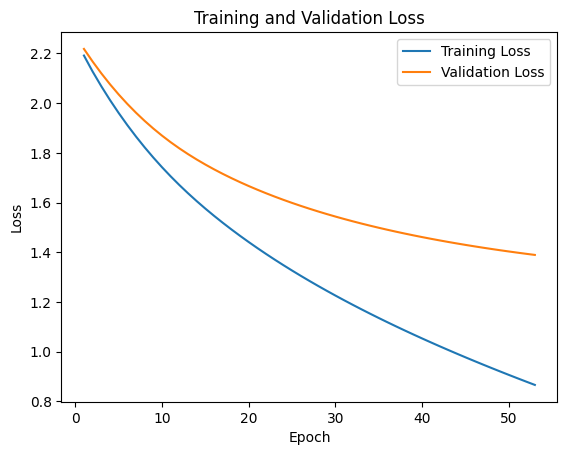

In [8]:
# Построение графика
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Здесь видно, что потери на валидационном наборе попрежнему высокие, что говорит о недостатке данных или о их качестве.

# Созданиие класса MineralClassifier

Создается класс MineralClassifier, который использует предварительно обученную модель CLIP для классификации изображений минералов.

In [9]:
class MineralClassifier:
    def __init__(self, model, processor, label_dict, device, data_file, root_dir=""):
        
        self.model = model
        self.processor = processor
        self.label_dict = label_dict
        self.device = device
        
        self.model.to(device)
        self.data_df = pd.read_csv(data_file)
        self.root_dir = root_dir
        
        self.embeddings = self.create_embeddings_dict()

    def load_test_data(self):
        test_image_paths = [os.path.join(self.root_dir, file) for file in self.data_df['path']]
        return test_image_paths

    def preprocess(self, images):
        inputs = self.processor(images=images, return_tensors="pt")
        return inputs    

    def get_clip_embeddings(self, image_paths):
        for path in image_paths:
            #print("Reading image from path:", path)
            images = [Image.open(path).convert("RGB")]
            inputs = self.preprocess(images=images)
 
            pixel_values = inputs["pixel_values"].to(self.device)

            with torch.no_grad():
                embeddings = self.model.get_image_features(pixel_values=pixel_values)

            mean_embedding = embeddings.mean(dim=0).to(self.device)

            return mean_embedding.cpu().numpy()

    def create_embeddings_dict(self):
        embeddings = {}
        minerals = self.data_df['en_name'].unique().tolist()
        for mineral_name in minerals:
            mineral_df = self.data_df.loc[self.data_df['en_name'] == mineral_name].copy()
            image_paths = mineral_df['path'].to_list()
            image_paths = [os.path.join(self.root_dir, file) for file in image_paths]
            mean_embedding = self.get_clip_embeddings(image_paths)
            embeddings[mineral_name] = mean_embedding
        
        return embeddings
    
    def get_embedding_for_image(self, image_path):
        images = [Image.open(image_path).convert("RGB")]
        inputs = self.processor(images=images, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(self.device)
        with torch.no_grad():
              embedding = self.model.get_image_features(pixel_values=pixel_values)
    
        return embedding
    
    def predict_topk(self, image_path, k=3):
        image_embedding = self.get_embedding_for_image(image_path)
        similarities = {}
        
        for mineral_name, embedding in self.embeddings.items():
            embedding_tens = torch.tensor(embedding).to(self.device)
            similarity = cosine_similarity(image_embedding, embedding_tens)
            similarities[mineral_name] = similarity
            
        sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        topk = sorted_similarities[:k]
        
        return topk
    
    def load_test_data(self):
        test_image_paths = [os.path.join(self.root_dir, file) for file in self.data_df['path']]
        # print("Test image paths:", test_image_paths)  # Добавленный вывод для проверки
        return test_image_paths
    
    def get_minerals(self):
        return self.data_df['en_name'].unique().tolist()

# Тестирование модели

Проводим тестирование модели, с использованием класса MineralClassifier

In [11]:
# checkpoint_path = "D:\\URFU2023\\pre_diploma\\checkpoints\\checkpoint_epoch_53.pt"

# Load the model checkpoint with map_location=torch.device('cpu')
# model_checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Now you can proceed with your code
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# model.load_state_dict(model_checkpoint['model_state_dict'])

# Загрузка процессора
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

mineral_dataset = MineralClipFineTuningDataset(clip_tokenizer, processor, transforms=transforms)
###print mineral-name-to-class id
print(mineral_dataset.label_dict)
###print mineral-name-to-class id
print(mineral_dataset.name_dict)

# Определение других параметров
label_dict = {
    'quartz': 0,
    'topaz': 1,
    'hematite': 2,
    'chalcedony': 3,
    'corundum': 4,
    'beryl': 5,
    'magnetite': 6,
    'agate': 7,
    'cassiterite': 8,
    'calcite': 9
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_file = "test.csv"  # Укажите путь к вашему файлу с тестовыми данными

classifier = MineralClassifier(model, processor, label_dict, device, data_file, root_dir="")
minerals = classifier.get_minerals()

# Загрузка тестовых данных
test_image_paths = classifier.load_test_data()

embeddings = []
labels = []

for mineral in minerals:
    mineral_dir = os.path.join(classifier.root_dir, "mineral_images", mineral)

    for file in os.listdir(mineral_dir):
        file_path = os.path.join(mineral_dir, file)  # Construct the full file path
        if file.endswith((".jpg", ".jpeg")):
            continue
        feat = classifier.get_embedding_for_image(file_path).cpu().numpy()  # Use file_path here
        embeddings.append(feat)
        labels.append(classifier.label_dict[mineral])

embeddings = np.squeeze(np.asarray(embeddings))
labels = np.asarray(labels)

for image_path in test_image_paths:
    topk_predictions = classifier.predict_topk(image_path, k=3)
    # Печать заголовка
    print(f"Top 3 predicted minerals for {image_path}:")
    # Печать каждой предсказанной минеральной метки и ее сходства
    for i, (mineral_name, similarity) in enumerate(topk_predictions, start=1):
        print(f"{i}. Predicted mineral: {mineral_name}, Similarity: {similarity.item():.4f}")


{'quartz': 0, 'topaz': 1, 'hematite': 2, 'chalcedony': 3, 'corundum': 4, 'beryl': 5, 'magnetite': 6, 'agate': 7, 'cassiterite': 8, 'calcite': 9}
{0: 'quartz', 1: 'topaz', 2: 'hematite', 3: 'chalcedony', 4: 'corundum', 5: 'beryl', 6: 'magnetite', 7: 'agate', 8: 'cassiterite', 9: 'calcite'}
Top 3 predicted minerals for mineral_images\magnetite\7ad4a258-dd61-4b4b-8e55-bf0c65fd0dff_IMG_2622.JPG:
1. Predicted mineral: magnetite, Similarity: 1.0000
2. Predicted mineral: corundum, Similarity: 0.8423
3. Predicted mineral: hematite, Similarity: 0.8047
Top 3 predicted minerals for mineral_images\chalcedony\2a7ffc85-6223-45ee-b7af-82d1f4a853cc_3353.jpg:
1. Predicted mineral: chalcedony, Similarity: 1.0000
2. Predicted mineral: corundum, Similarity: 0.7868
3. Predicted mineral: hematite, Similarity: 0.7853
Top 3 predicted minerals for mineral_images\quartz\712d4f08-799c-494e-aae7-e5075c32c45f_1_22302.jpg:
1. Predicted mineral: quartz, Similarity: 1.0000
2. Predicted mineral: calcite, Similarity: 0

Здесь мы видимм что выводятся top- 3 предсказания. Список меток выводится для проверки.

### Тестирование модели с предсказанными и истинными метками

In [ ]:
true_labels = []
topk_predictions_list = []

# Предсказания для всех тестовых изображений
for image_path in test_image_paths:
    # Предположим, что в имени файла есть информация о метке, которая может быть использована как истинная метка
    true_label = os.path.basename(os.path.dirname(image_path))
    true_labels.append(true_label)
    
    # Получаем предсказанные метки для top-k
    topk_predictions = classifier.predict_topk(image_path, k=3)
    topk_labels = [label for label, _ in topk_predictions]  # Извлекаем только метки из кортежей предсказаний
    topk_predictions_list.append(topk_labels)

# Преобразуем истинные метки в числовые форматы для вычисления метрик
true_labels = [label_dict[label] for label in true_labels]

# Преобразуем предсказания top-k в числовые форматы для вычисления метрик
topk_predictions_list = [[label_dict[label] for label in topk] for topk in topk_predictions_list]

# Преобразуем списки в тензоры
true_labels_tensor = torch.tensor(true_labels)
topk_predictions_tensor = torch.tensor(topk_predictions_list)

# Вычисляем top-k accuracy
num_correct_topk = sum([1 if true_label in topk_preds else 0 for true_label, topk_preds in zip(true_labels, topk_predictions_list)])
total_samples = len(true_labels)
accuracy_topk = num_correct_topk / total_samples

print("Top-3 Accuracy:", accuracy_topk)


Top-3 Accuracy: 0.5831043956043956


In [ ]:
print(minerals)

['magnetite', 'chalcedony', 'quartz', 'topaz', 'calcite', 'cassiterite', 'corundum', 'hematite', 'beryl', 'agate']


In [ ]:
print(type(image_path))

<class 'str'>


# Визуализация признаков

Для визуализации признаков создаем функции визуализации 

In [ ]:
def plot_features(embeddings, labels, method_name):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap="viridis", edgecolor="k", alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f"Feature Visualization using {method_name}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

def plot_features_3d(embeddings, labels, method_name):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=labels, cmap='viridis', edgecolor='k', alpha=0.6)
    cbar = fig.colorbar(scatter, shrink=0.5, aspect=5)
    cbar.set_label('Labels')
    ax.set_title(f'3D Visualization using {method_name}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()


## Визуализация признаков 2D

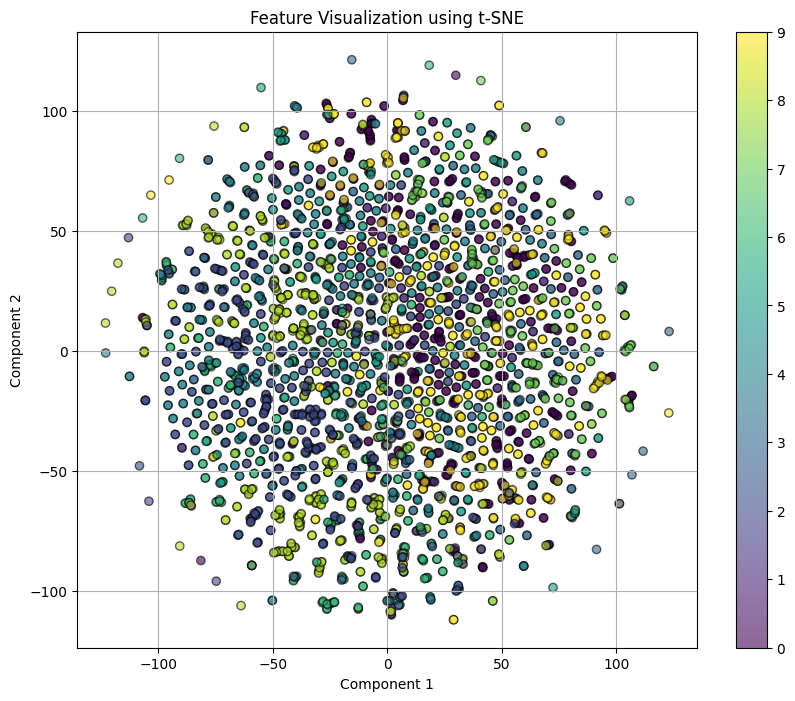

In [ ]:
tsne = TSNE(n_components=2, perplexity=1, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)
plot_features(embeddings_tsne, labels, "t-SNE")

Здесь видно, что признаки разеделились очень слабо

## Визуализация признаков 3D

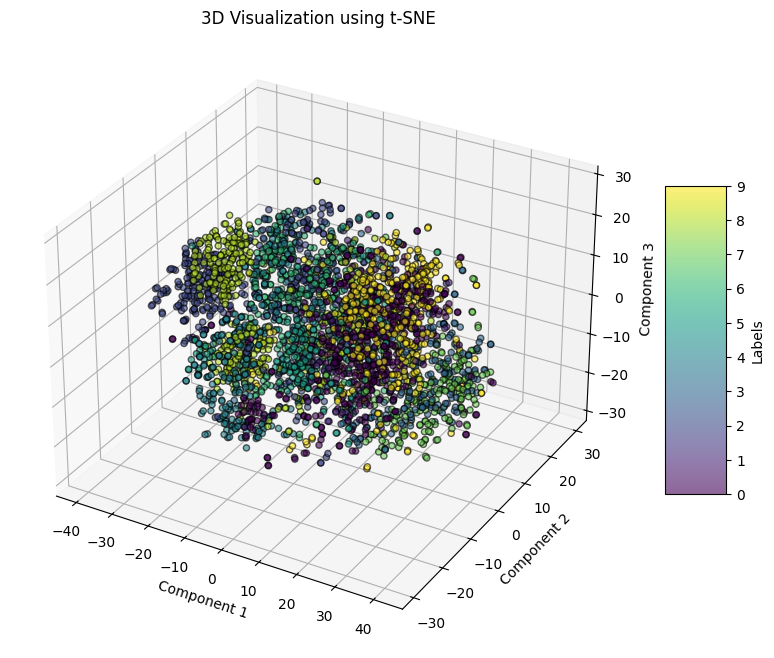

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)
plot_features_3d(embeddings_tsne, labels, "t-SNE")

На этой скатерограмме видно, что ризнаки разделились, но недостаточно.

Визуализации как им етрики указывают на то что модели не хватило данных для обучения.

Accuracy: 29.53%
              precision    recall  f1-score   support

   magnetite       0.45      0.26      0.33       104
  chalcedony       0.32      0.15      0.21        98
      quartz       0.13      0.45      0.21        69
       topaz       0.05      0.02      0.02       127
     calcite       0.16      0.20      0.17       133
 cassiterite       0.29      0.25      0.27        85
    corundum       0.22      0.69      0.34       128
    hematite       0.05      0.02      0.03       110
       beryl       0.65      0.39      0.49       416
       agate       0.35      0.30      0.32       186

    accuracy                           0.30      1456
   macro avg       0.27      0.27      0.24      1456
weighted avg       0.35      0.30      0.29      1456



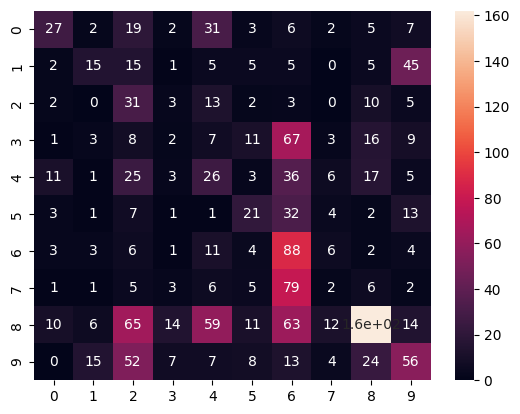

In [ ]:
# Предсказания для всех тестовых изображений
predicted_labels = []
true_labels = []

for image_path in test_image_paths:
    topk_predictions = classifier.predict_topk(image_path, k=1)  # Получаем только самую вероятную метку
    predicted_labels.append(topk_predictions[0][0])  # Первый элемент кортежа - это предсказанная метка
    # Предположим, что в имени файла есть информация о метке, которая может быть использована как истинная метка
    true_labels.append(os.path.basename(os.path.dirname(image_path)))

# Вычисляем точность классификации
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Создаем отчет о классификации
class_report = classification_report(true_labels, predicted_labels, target_names=minerals)
print(class_report)

cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True)
plt.show()